# Tutorial for MIRI coronagraphy reduction with spaceKLIP

In this notebook we will reduce the MIRI coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems, program 1386. 




<div class="alert alert-warning">
<b>Relation to other tutorials:</b> This notebook is intentionally very similar to the NIRCam data reduction notebook.  Subsequent analyses steps will be carried out in the MIRI post-pipeline analyses notebook. 
</div>

<div class="alert alert-info">
<b>MIRI-specific information:</b> Steps and information specific to MIRI are called out in blue.</div>

## Table of Contents:
* [Setup and imports](#Setup-and-imports)
* [Download tutorial data](#Precursor:-Download-the-data,-if-you-don't-already-have-it.)
* [Level 1 reductions](#Level-1-reductions)
* [Level 2 reductions](#Level-2-reductions)
* [Level 3 reductions: Preparations](#Level-3-reductions:-Preparations)
* [Level 3 reductions: KLIP](#Level-3-reductions:-KLIP)


## Setup and imports

In [1]:
import os
import pdb
import sys
import glob

import numpy as np
import astropy.io.fits as fits

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import spaceKLIP

Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We'll mostly ignore the output log text. 

## Precursor: Download the data, if you don't already have it. 

If you already have a copy of this data, then you can adjust paths below. For this notebook, we assume you don't already have the data. So let's download it here. 


We can do this using the (jwst_mast_query)[https://github.com/spacetelescope/jwst_mast_query] package.  Consult that package's own documentation for more. 

We download all the uncalibrated raw data (`uncal.fits`), since we will use spaceKLIP to invoke the jwst pipeline with some customized options and extra steps optimized for coronagraphy. 

In [2]:
data_root = 'data_miri_hd65426'

In [3]:
# make subdirectories to put these data in

if not os.path.isdir(data_root):
    
    os.makedirs(data_root)
    os.makedirs(os.path.join(data_root, 'uncal'))
    

    # invoke the download
    !jwst_download.py --propID 1386 -i miri -l 700 --obsnums 4 5 6 7 8 9 28 29 30 31 --outsubdir data_miri_hd65426/uncal -f uncal    

## Level 1 reductions

### Index files into database for level 1

SpaceKLIP relies on a `Database` class to track observations, data files, and the relationships between them. 

We begin by creating a database, and reading files into it. 

For purposes of this tutorial, let's only reduce one filter's worth of data.

In [6]:
filt = 'F1550C' # set this to None to disable filter selection when loading data in, and load all filters

In [7]:
input_dir = os.path.join(data_root, 'uncal')
output_dir = data_root  # subdirectories will automatically be created within this

In [9]:
# Initialize spaceKLIP database.
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'uncal'),
                                              output_dir=data_root, 
                                              filt=filt,
                                              pid=1386)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP       TARGPROP       INSTRUME DETECTOR FILTER       CWAVEL       ... EFFINTTM SUBARRAY NUMDTHPT XOFFSET YOFFSET   PIXSCALE  BUNIT      ROLL_REF      BLURFWHM
------ -------- -------- -------- -------------------- -------- -------- ------ ------------------ ... -------- -------- -------- ------- ------- ----------- ----- ------------------ --------
   SCI MIR_4QPM   STAGE0     JWST            HIP-65426     MIRI MIRIMAGE F1550C 15.514663275230946 ...    59.92 MASK1550        1     0.0     0.0 0.110531925    DN   108.171119832454      nan
   SCI MIR_4QPM   STAGE0     JWST            HIP-65426     MIRI MIRIMAGE F1550C 15.514663275230946 ...    59.92 MASK1550        1     0.0     0.0 0.110531925    DN  117.5498733620294      nan
SCI_BG MIR_4QPM   STAGE0     JWST HIP-65426-BACKGROUND     MIRI MIRIMAGE 

The above is a bit verbose and can be hard for a human to parse; let's ask the database to summarize what it contains: 

In [10]:
database.summarize()

MIRI_F1550C_4QPM
	STAGE0: 15 files;	2 SCI, 9 REF, 4 BG


### Run level 1 reductions

We use spaceKLIP to invoke the level 1 pipeline, with a handful of parameter customizations.

This will run the Detector1 pipeline for all input data, saving the output to a subdirectory named `stage1`.

This can take a long time to run, so be patient. 

In [ ]:
spaceKLIP.coron1pipeline.run_obs(database=database,
                       steps={'saturation': {'n_pix_grow_sat': 1,
                                             'grow_diagonal': False},
                              'refpix': {'odd_even_columns': True,
                                         'odd_even_rows': True,
                                         'nlower': 0,
                                         'nupper': 0,
                                         'nleft': 0,
                                         'nright': 0,
                                         'nrow_off': 0,
                                         'ncol_off': 0},
                              'dark_current': {'skip': True},
                              'jump': {'rejection_threshold': 8.,
                                       'three_group_rejection_threshold': 8.,
                                       'four_group_rejection_threshold': 8.,
                                       'maximum_cores': 'all'},
                              'ramp_fit': {'save_calibrated_ramp': False,
                                           'maximum_cores': 'all'}},
                       )

[spaceKLIP.coron1pipeline:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386008001_04101_00001_mirimage_uncal.fits


We can now examine the database, and it shows that all the available files for both filters have now been processed to Stage 1. 

(The stage 0 files are removed from the database automatically since there is nothing more to do with them, though the files remain on disk of course)

In [ ]:
database.summarize()

### Display the results of the level 1 reductions

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to=filt, save_filename=f'plots_{filt}_stage1.pdf')

## Level 2 reductions

### Optional: Re-read level 1 outputs into database 
This shows how you can start re-reductions at this point, once you have run the previous steps. 

In [ ]:
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'stage1'),
                                              file_type='rateints.fits',
                                              output_dir=data_root, 
                                              pid=1386)

### Run level 2 pipeline

Now we run the stage 2 pipeline. Little customization is needed here. 

In [ ]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                           steps={'outlier_detection': {'skip': False}},
                           )

And again, we can check the database now contains level 2 reduces versions of all the files:

In [ ]:
database.summarize()

### Display the results of the level 2 reductions

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to=filt, save_filename=f'plots_{filt}_stage2.pdf')

## Level 3 reductions: Preparations

### Preparations for PSF subtraction:

As is often the case in high contrast imaging, getting good PSF subtractions depends sensitively on preparing the data ahead of time. 

Here we take special care about image centering, background subtractions, and bad pixel replacement/interpolation, all prior to the PSF subtraction steps

### Optional: Re-read level 2 outputs into database 
This shows how you can start re-reductions at this point, once you have run the previous steps. 

In [6]:
input_dir = os.path.join(data_root, 'stage2')
    
fitsfiles = sorted(glob.glob(os.path.join(input_dir, "*_calints.fits")))

database = spaceKLIP.database.Database(output_dir=output_dir)
database.read_jwst_s012_data(datapaths=fitsfiles,
                             assoc_using_targname=False)
 

 TYPE  EXP_TYPE DATAMODL TELESCOP       TARGPROP       INSTRUME DETECTOR FILTER      CWAVEL          DWAVEL      PUPIL  CORONMSK NINTS EFFINTTM SUBARRAY NUMDTHPT XOFFSET YOFFSET  PIXSCALE  BUNIT       ROLL_REF      BLURFWHM
------ -------- -------- -------- -------------------- -------- -------- ------ --------------- ---------------- ----- --------- ----- -------- -------- -------- ------- ------- ---------- ------ ------------------ --------
SCI_TA MIR_TACQ   STAGE2     JWST            HIP-65426     MIRI MIRIMAGE    FND            13.0             10.0  NONE      NONE     1 10.54592 MASK1140        1     0.0     0.0 110.917025   DN/s   108.049052294396      nan
SCI_TA MIR_TACQ   STAGE2     JWST            HIP-65426     MIRI MIRIMAGE    FND            13.0             10.0  NONE      NONE     1 10.54592 MASK1140        1    39.0   144.0 110.917025   DN/s  108.0490988361535      nan
   SCI MIR_4QPM   STAGE2     JWST            HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.603653


<div class="alert alert-info">
<b>MIRI-specific information:</b> The following steps to update the coronagraph mask location is just required for MIRI right now. </div>


### <font color='red'>Special additional step needed for re-reductions of early JWST data</font>

Here we have to pause for an awkward technical complication, to work around some limitations of the current system.  

Both the on-board operations scripts and the pipeline rely on information about coronagraph mask center locations recorded in the Science Instrument Aperture File (SIAF). Those values have changed over time, as knowledge improved. 

The ERS observations in July-August 2022 used the SIAF values _at that time_. In particular the operations scripts on board used those values for where the Target Acquisition steps should place the target. 

However the pipeline code running now will by default  retrieve the _current_ calibrated values, which would not be correct for where the star was located in these data. A (pipeline ticket)[https://github.com/spacetelescope/jwst/issues/7597] has been filed to request improved handling for this. 

Pending some future improved system for this, for now we must manually adjust the database metadata to use the old centering information, from the time of the ERS observations

In [7]:
# Adjust CRPIX and YOFFSET values to the coron mask reference locations used in the onboard scripts for these data
crpix1 = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 119.5,
          'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 119.5}
crpix2 = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 112.5,
          'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 113.0}
xoffset = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 219.,
           'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 226.}
yoffset = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 127.,
           'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 156.}
for key in database.obs.keys():
    for j in range(len(database.obs[key])):
        database.obs[key]['CRPIX1'][j] = crpix1[key]
        database.obs[key]['CRPIX2'][j] = crpix2[key]
        if 'BG' not in database.obs[key]['TYPE'][j]:
            database.obs[key]['XOFFSET'][j] -= xoffset[key]
            database.obs[key]['YOFFSET'][j] -= yoffset[key]


### <font color='red'>End of special additional step needed for re-reductions of early JWST data</font>


### Extra image processing to improve coronagraphic reductions

In [8]:
# Initialize spaceKLIP image manipulation tools class.
imageTools = spaceKLIP.imagetools.ImageTools(database=database)


In [9]:
# Remove first frame due to reset switch charge delay. Only required for
# MIRI.
imageTools.remove_frames(index=[0],
                         types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                         subdir='removed')




<div class="alert alert-info">
<b>MIRI-specific information:</b> The bad pixel flagging for MIRI has a lot of manual adjustments as described below. </div>


For MIRI, the JWST pipeline does not sufficiently flag bad pixels within the coronagraphic subarrays. 
The automatic spaceKLIP routines are also not working great yet for MIRI, because they were optimized for NIRCam.

For the ERS reduction, team members had to look at the reduced background frames and identify these bad pixels by eye. This resulted in the following list of manually-detected and flagged outlier pixels. 

They should remain the same for each subarray, so the following lists can be used as reasonable starting points
for other datasets (but may require some fine tuning, as the population of anomalous pixels in the MIRI detector
is known to vary over time)

In [10]:
# Identify and fix bad pixels using custom spaceKLIP routines. Multiple
# routines can be combined in a custom order by joining them with + signs.
# - bpclean: use sigma clipping to identify additional bad pixels.
# - custom:  use a custom bad pixel map.
# - timemed: replace pixels which are only bad in some frames with their
#            median value from the good frames.
# - dqmed:   replace bad pixels with the median of the surrounding good
#            pixels.
# - medfilt: replace bad pixels with an image plane median filter.


# Here we use a custom bad pixel mask, with a lot of values that were determined (how?)
# during the ERS reductions

custom_kwargs = {}
bpmap = np.zeros((224, 288))
bpmap[ 28, 171] = 1
bpmap[ 29, 171] = 1
bpmap[ 52, 184] = 1
bpmap[ 70,  94] = 1
bpmap[ 75, 150] = 1
bpmap[ 76, 148] = 1
bpmap[ 79, 149] = 1
bpmap[ 83, 156] = 1
bpmap[ 84, 156] = 1
bpmap[ 86,  50] = 1
bpmap[ 87, 134] = 1
bpmap[ 87, 140] = 1
bpmap[ 89, 141] = 1
bpmap[ 93, 142] = 1
bpmap[ 95, 116] = 1
bpmap[ 98, 172] = 1
bpmap[102,  38] = 1
bpmap[102,  86] = 1
bpmap[103,  38] = 1
bpmap[106,  52] = 1
bpmap[106, 114] = 1
bpmap[109,  88] = 1
bpmap[110, 136] = 1
bpmap[110, 147] = 1
bpmap[111, 125] = 1
bpmap[111, 158] = 1
bpmap[112, 136] = 1
bpmap[114,  84] = 1
bpmap[116, 116] = 1
bpmap[118,  30] = 1
bpmap[125, 156] = 1
bpmap[129, 163] = 1
bpmap[137, 128] = 1
bpmap[138, 102] = 1
bpmap[144, 120] = 1
bpmap[154, 120] = 1
bpmap[154, 157] = 1
bpmap[155, 171] = 1
bpmap[161,  98] = 1
bpmap[163, 144] = 1
bpmap[184, 122] = 1
bpmap[192, 126] = 1
bpmap[192, 176] = 1
bpmap[196, 172] = 1
custom_kwargs['JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140'] = bpmap.copy()

bpmap = np.zeros((224, 288))
bpmap[ 88, 166] = 1
bpmap[101, 160] = 1
bpmap[105, 179] = 1
bpmap[107, 132] = 1
bpmap[110, 172] = 1
bpmap[111,  66] = 1
bpmap[112, 136] = 1
bpmap[115, 140] = 1
bpmap[115, 199] = 1
bpmap[118, 184] = 1
bpmap[130, 176] = 1
bpmap[131,  74] = 1
bpmap[136, 122] = 1
bpmap[157,  64] = 1
bpmap[162,  68] = 1
bpmap[163, 164] = 1
custom_kwargs['JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550'] = bpmap.copy()

In [11]:
imageTools.fix_bad_pixels(method='custom+timemed+dqmed+medfilt',
                          bpclean_kwargs={'sigclip': 5,
                                          'shift_x': [-1, 0, 1],
                                          'shift_y': [-1, 0, 1]},
                          custom_kwargs=custom_kwargs,
                          timemed_kwargs={},
                          dqmed_kwargs={'shift_x': [-1, 0, 1],
                                        'shift_y': [-1, 0, 1]},
                          medfilt_kwargs={'size': 4},
                          subdir='bpcleaned')


### MIRI background subtraction


In [12]:
# Perform background subtraction to remove MIRI thermal background and glowstick. 
# This step is only required for MIRI.
imageTools.subtract_background(nsplit=9,
                                   subdir='bgsub')


In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F1140C', save_filename='bgsub/plots_f1140c_bgsub.pdf')

### Finish pixel cleanup

In [13]:
# Replace all nans.
imageTools.replace_nans(cval=0.,
                            types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                            subdir='nanreplaced')

 

In [14]:
# Pad all frames.
imageTools.pad_frames(npix=160,
                      cval=np.nan,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')


### Display the cleaned datasets after all of the above

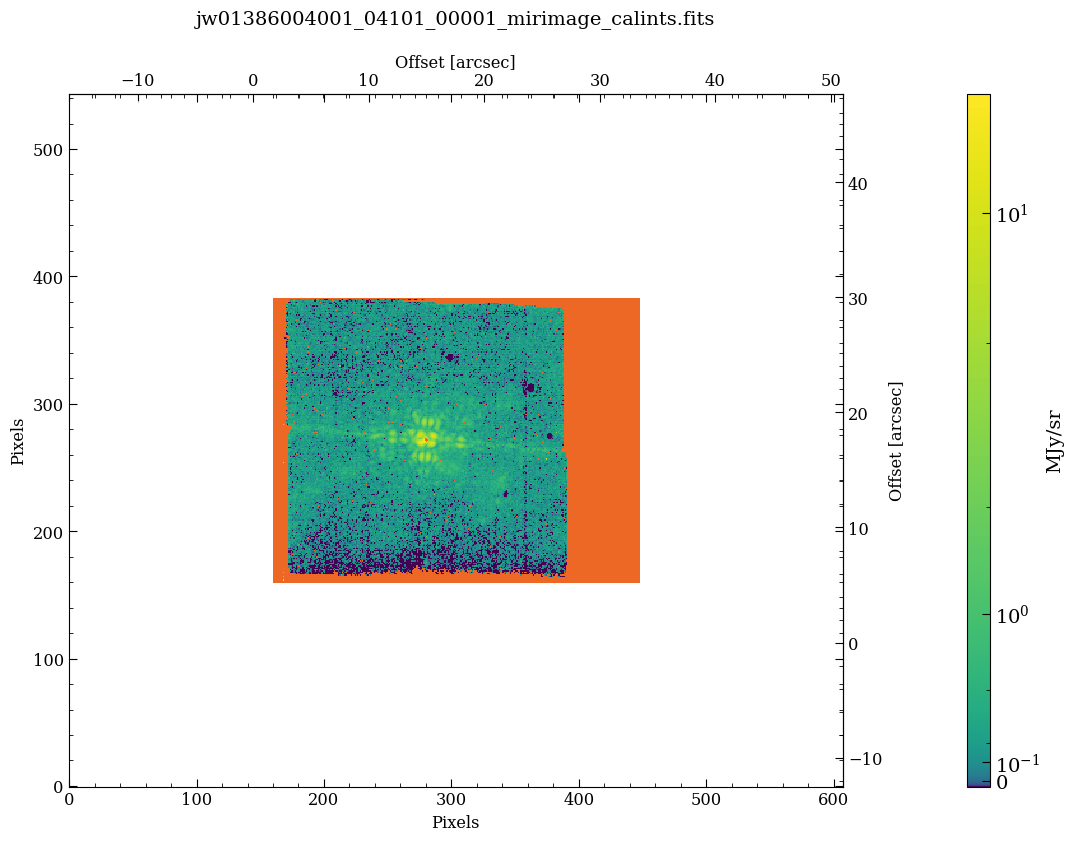

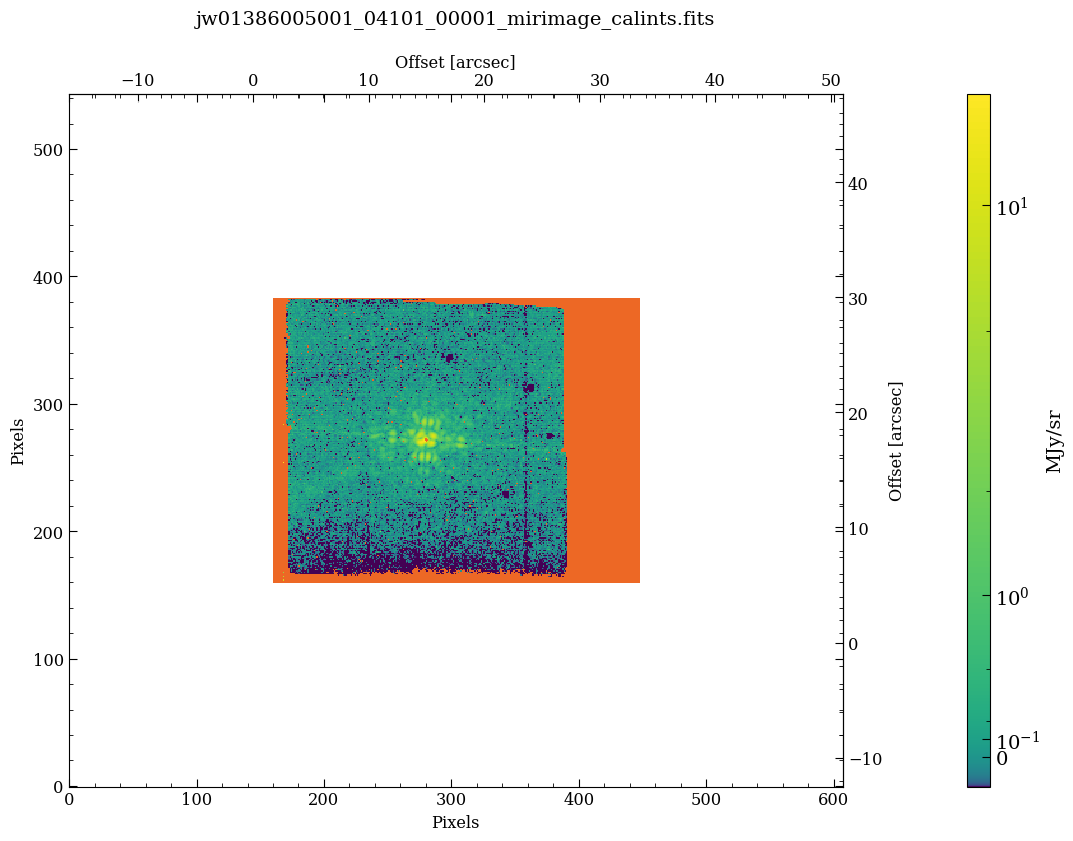

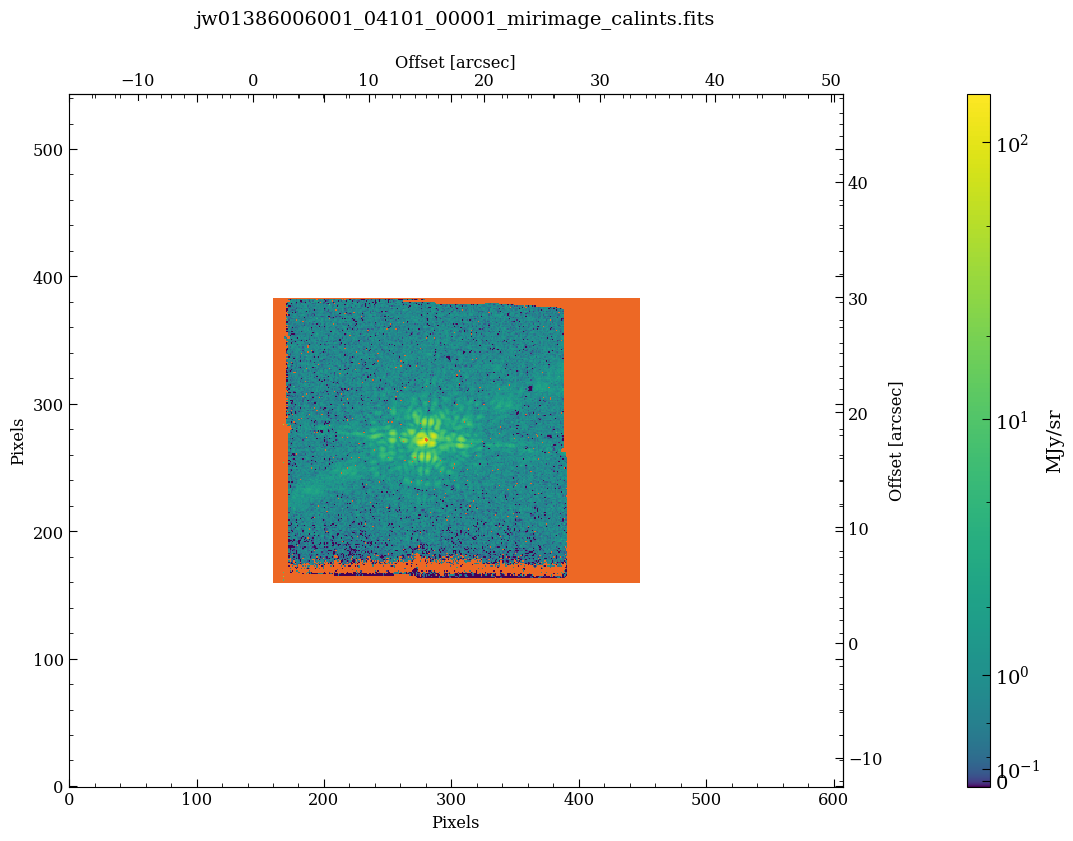

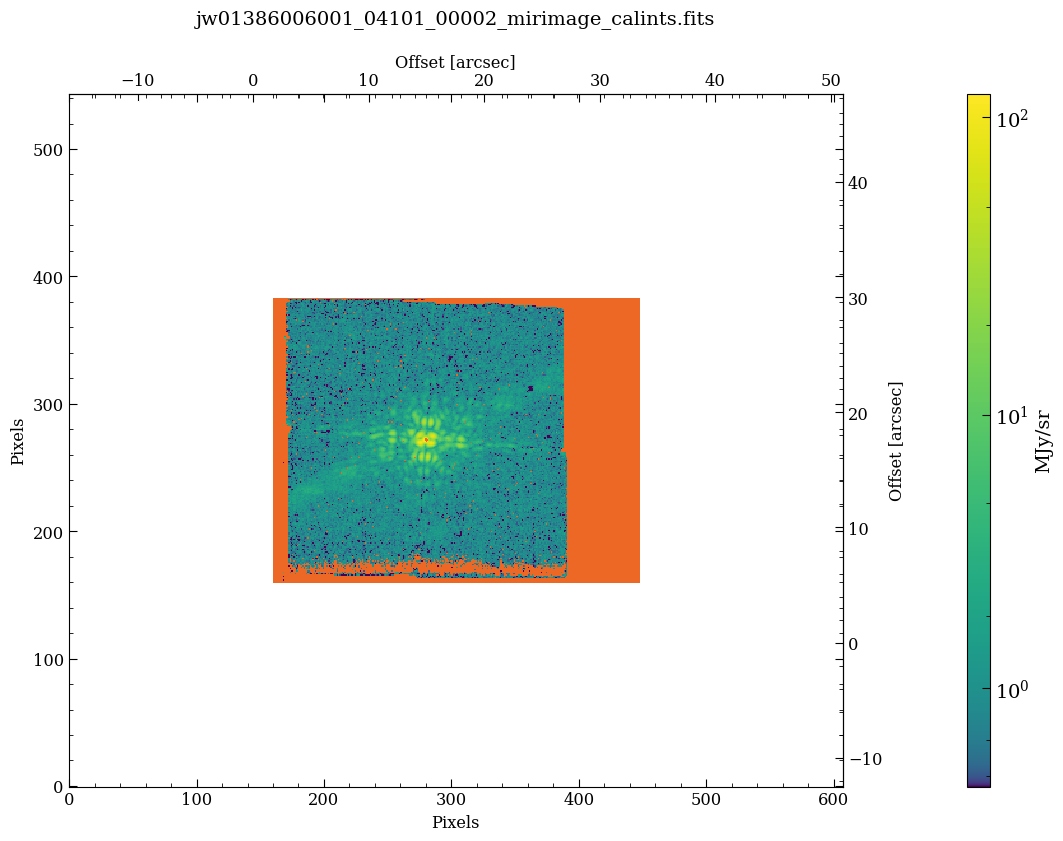

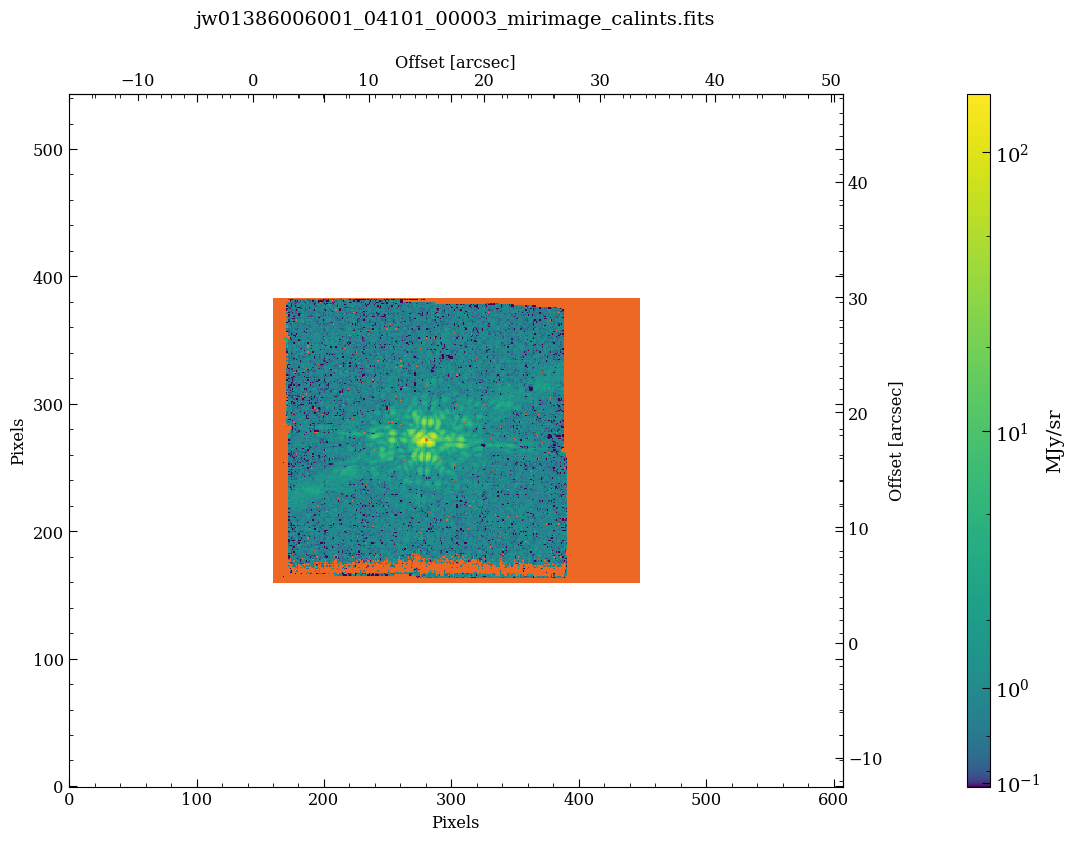

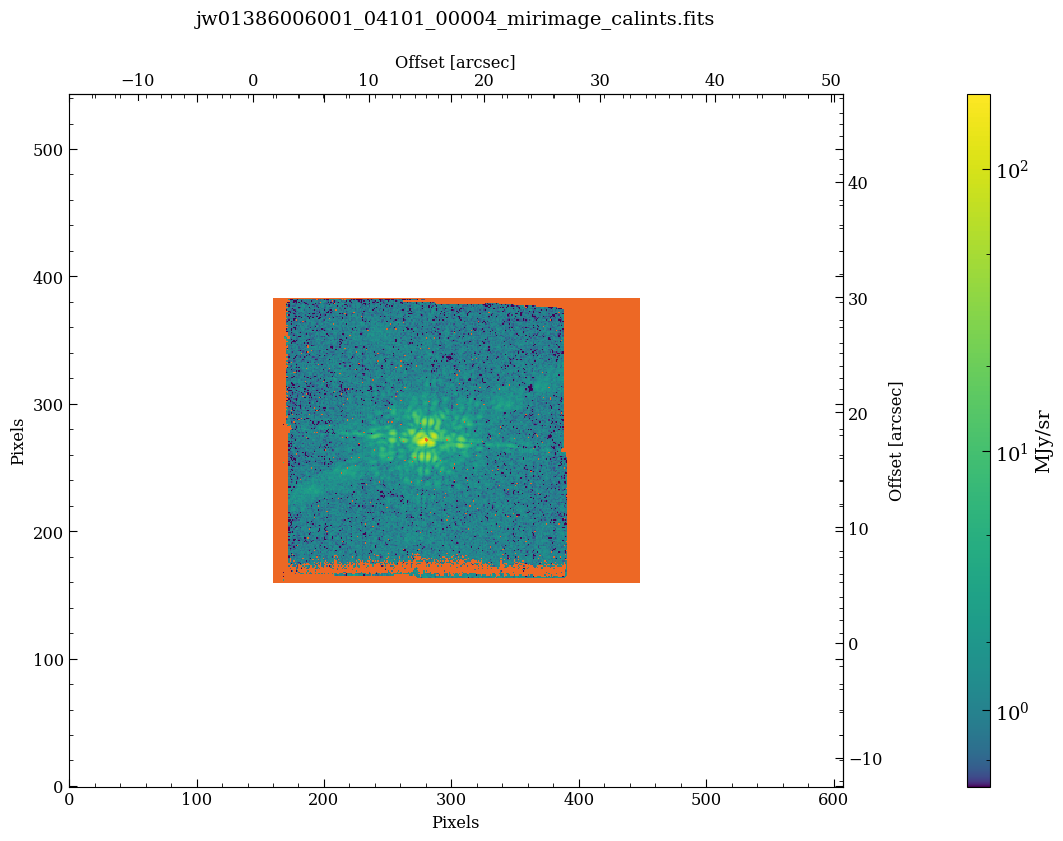

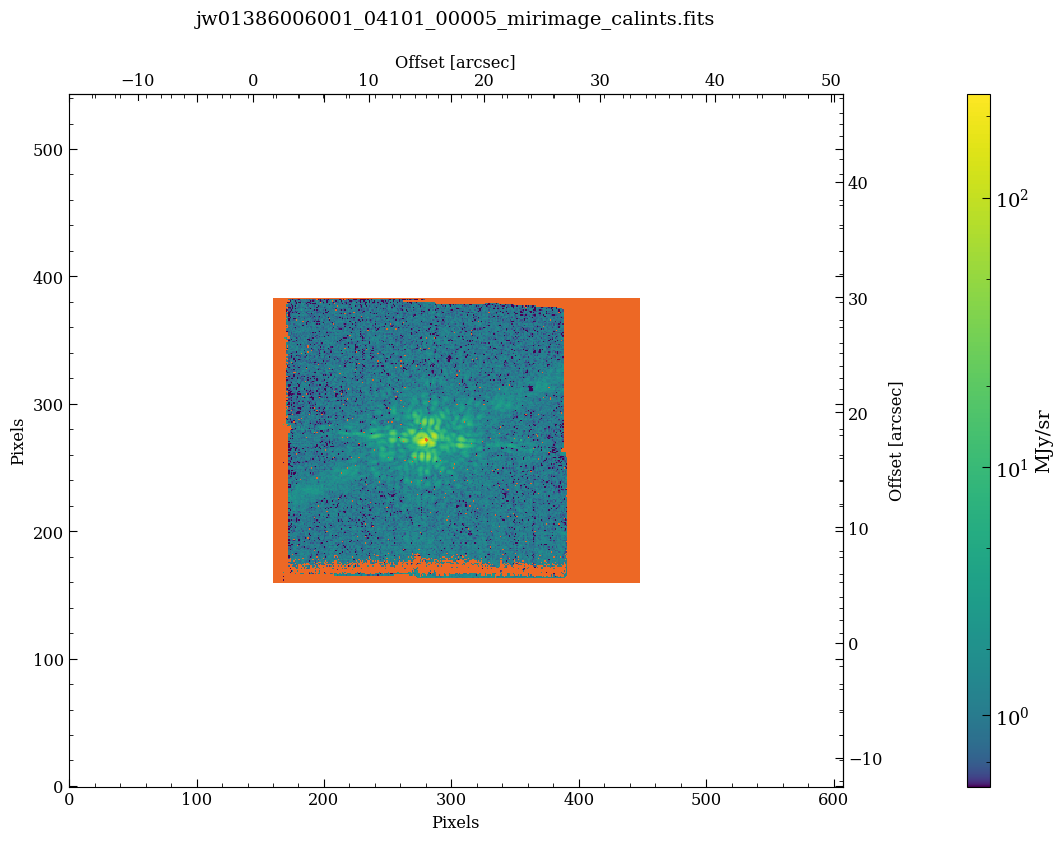

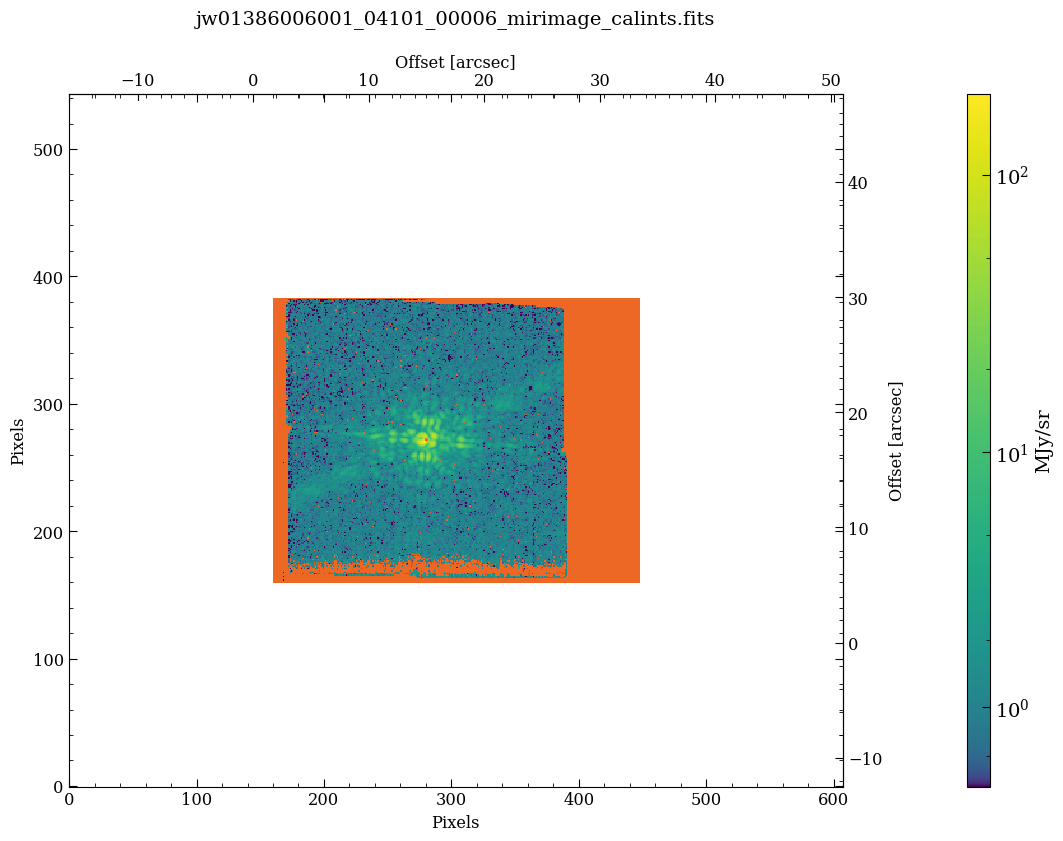

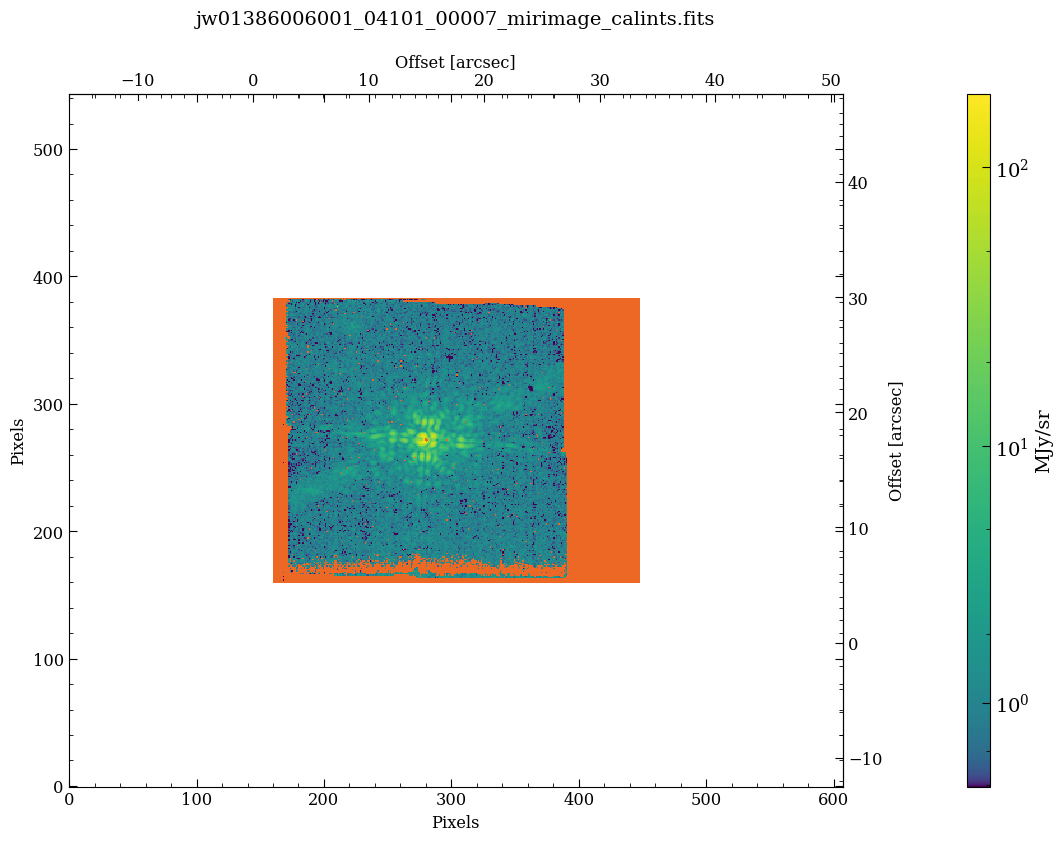

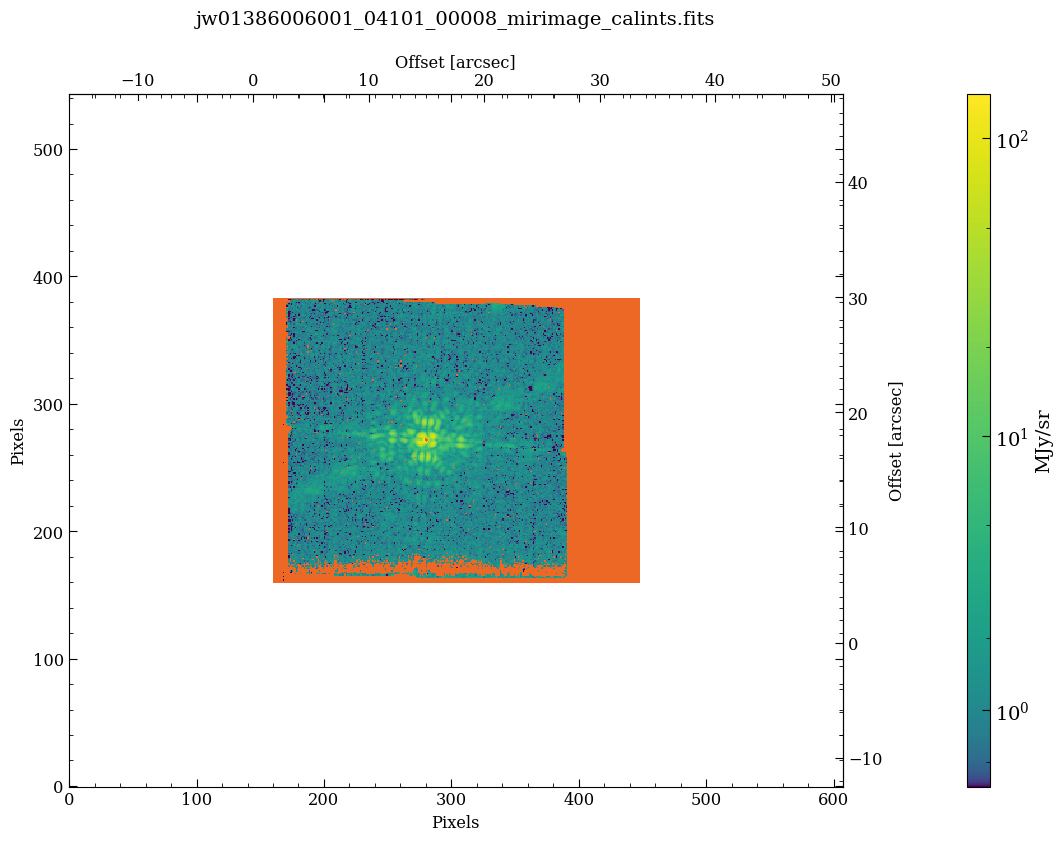

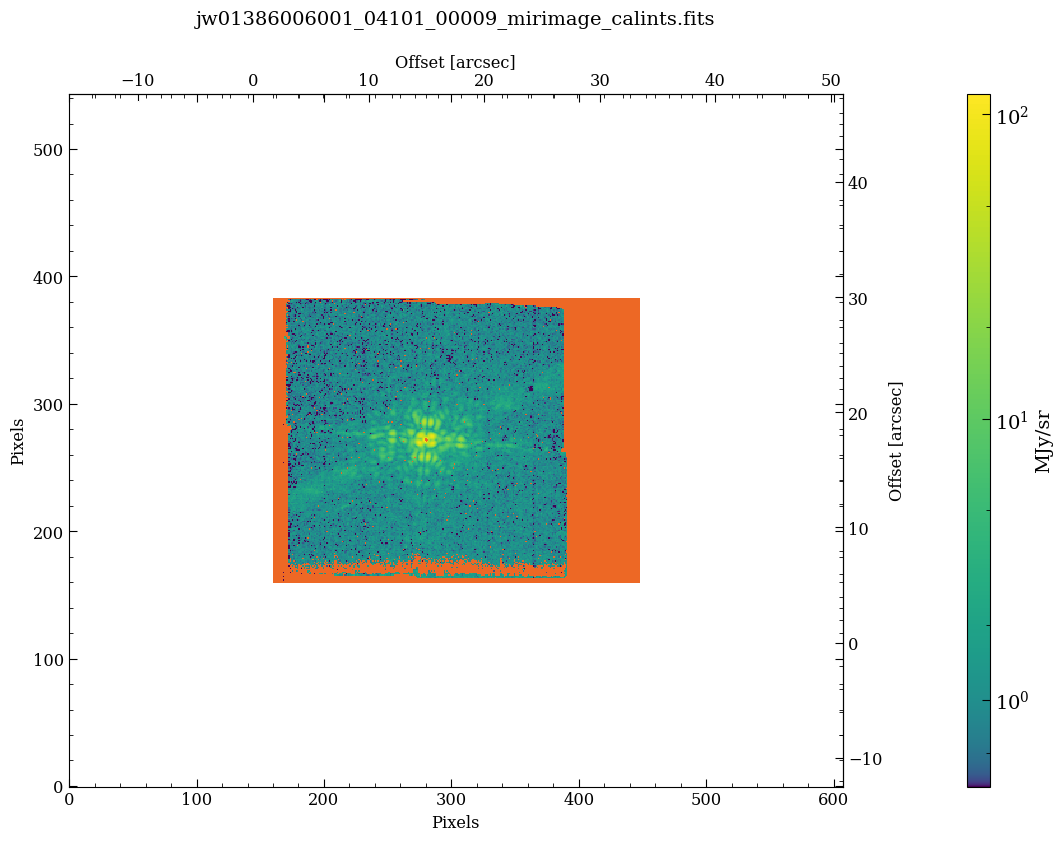

In [15]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F1140C', save_filename='plots_f1140c_stage2_cleaned.pdf')

## Level 3 reductions: KLIP

### PSF Subtraction: option using pyKLIP

SpaceKLIP supports multiple algorithms for PSF subtraction, including pyKLIP (recommended) as well as the 
 jwst pipeline Coron3Pipeline. Here we use a pyKLIP subtraction. 

In [16]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['ADI', 'RDI', 'ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')


Begin align and scale images for each wavelength
Wavelength 1.132e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 80, 1, 544, 608)
Begin align and scale images for each wavelength
Wavelength 1.132e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 80, 1, 544, 608)
Begin align and scale images for each wavelength
Wavelength 1.132e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 80, 1, 544, 608)
Begin align and scale images for each wavelength
Wavelength 1.552e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 118, 1, 544, 608)
Begin align and scale images for each wavelength
Wavelength 1.552e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 118, 1, 544, 608)
Begin align and scale images for each wavelength
Wavelength 1.552e-05 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /Users/mperrin/Dropbox (Personal)/Documents/software/git/spaceKLIP/notebooks/data_miri_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(13, 118, 1, 544, 608)
 TYPE  EXP_TYPE DATAMODL TELESCOP  TARGPROP INSTRUME DETECTOR FILTER      CWAVEL          DWAVEL      PUPIL  CORONMSK NINTS EFFINTTM SUBARRAY  PIXSCALE    MODE  ANNULI SUBSECTS            KLMODES             BUNIT  BLURFWHM
------ -------- -------- -------- --------- -------- -------- ------ --------------- ---------------- ----- --------- ----- -------- -------- ---------- ------- ------ -------- ------------------------------ ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  NONE 4QPM_1140    80 24.20768 MASK1140 110.917025     ADI      1        1 1,2,3,4,5,6,7,8,9,10,20,50,100 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.3

In [8]:
database.summarize()

MIRI_F1140C_4QPM
	STAGE2: 21 files;	2 SCI, 9 REF, 6 TA, 4 BG
	STAGE3: 3 files;	3 PYKLIP
MIRI_F1550C_4QPM
	STAGE2: 21 files;	2 SCI, 9 REF, 6 TA, 4 BG
	STAGE3: 3 files;	3 PYKLIP


### Optional: Re-read level 3 outputs into database 
This shows how you can start re-analyses at this point, once you have run the previous steps. 

In [7]:
input_dir = os.path.join(data_root, 'klipsub')
    
fitsfiles = sorted(glob.glob(os.path.join(input_dir, "*KLmodes-all.fits")))

database = spaceKLIP.database.Database(output_dir=output_dir)
database.read_jwst_s3_data(fitsfiles)

 TYPE  EXP_TYPE DATAMODL TELESCOP  TARGPROP INSTRUME DETECTOR FILTER      CWAVEL          DWAVEL      PUPIL  CORONMSK NINTS EFFINTTM SUBARRAY  PIXSCALE    MODE  ANNULI SUBSECTS            KLMODES             BUNIT  BLURFWHM
------ -------- -------- -------- --------- -------- -------- ------ --------------- ---------------- ----- --------- ----- -------- -------- ---------- ------- ------ -------- ------------------------------ ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  NONE 4QPM_1140    80 24.20768 MASK1140 110.917025 ADI+RDI      1        1 1,2,3,4,5,6,7,8,9,10,20,50,100 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  NONE 4QPM_1140    80 24.20768 MASK1140 110.917025     ADI      1        1 1,2,3,4,5,6,7,8,9,10,20,50,100 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  N

UnboundLocalError: cannot access local variable 'cube' where it is not associated with a value

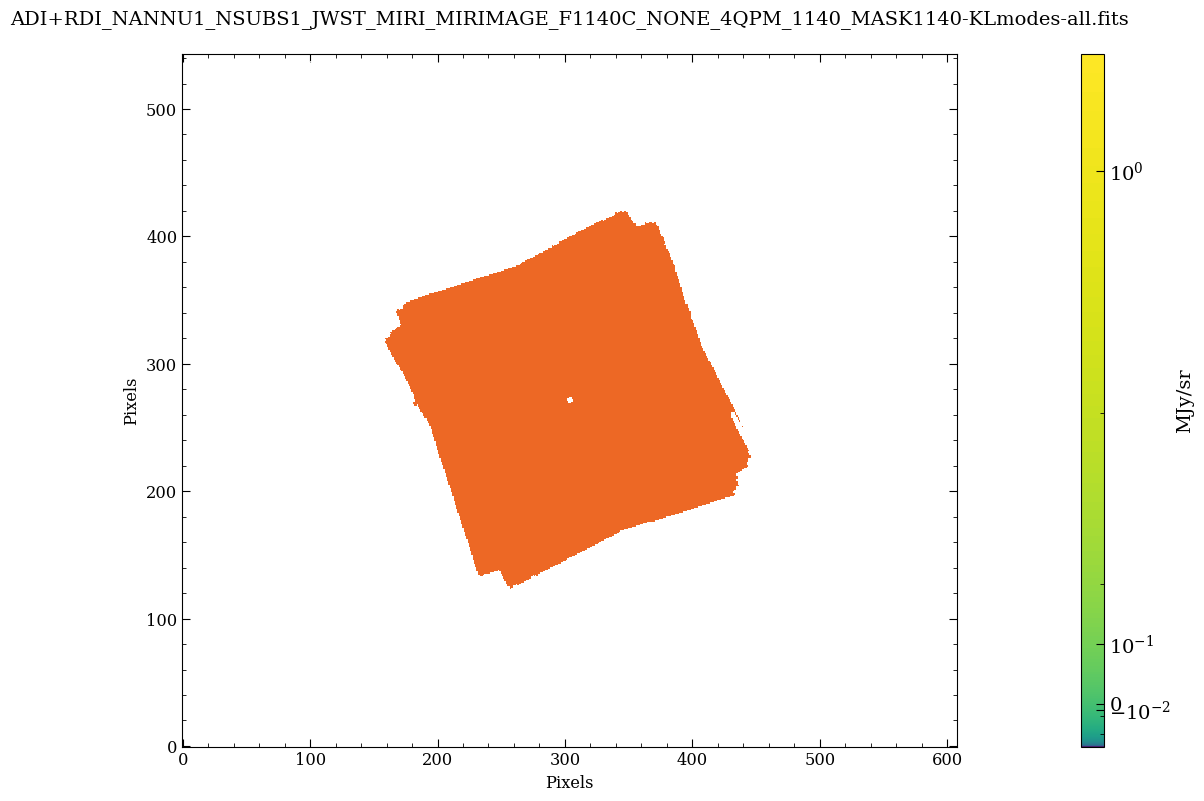

In [8]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F1140C', save_filename='plots_f1140c_pyklip.pdf')

In [ ]:

from spaceKLIP import database, imagetools, coron1pipeline, coron2pipeline,\
    coron3pipeline, pyklippipeline, classpsfsubpipeline, analysistools



# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":

    # Set input and output directories and get uncal files.
    # idir = 'uncal/'
    idir = 'spaceklip/stage2/'
    # idir = 'spaceklip/klipsub/'
    odir = 'spaceklip/'
    
    # Get FITS files.
    # fitsfiles = sorted([idir + f for f in os.listdir(idir) if
    #                     f.endswith('_uncal.fits')])
    fitsfiles = sorted([idir + f for f in os.listdir(idir) if
                        f.endswith('_calints.fits')])
    # fitsfiles = sorted([idir + f for f in os.listdir(idir) if
    #                     f.endswith('-KLmodes-all.fits')
    #                     and 'ADI+RDI' in f])

    # Initialize spaceKLIP database.
    Database = database.Database(output_dir=odir)
    
    # Read FITS files.
    Database.read_jwst_s012_data(datapaths=fitsfiles,
                                 bgpaths=None,
                                 assoc_using_targname=False)
    # Database.read_jwst_s3_data(datapaths=fitsfiles)

    crpix1 = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 119.5,
              'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 119.5}
    crpix2 = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 112.5,
              'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 113.0}
    xoffset = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 219.,
               'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 226.}
    yoffset = {'JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140': 127.,
               'JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550': 156.}
    for key in Database.obs.keys():
        for j in range(len(Database.obs[key])):
            Database.obs[key]['CRPIX1'][j] = crpix1[key]
            Database.obs[key]['CRPIX2'][j] = crpix2[key]
            if 'BG' not in Database.obs[key]['TYPE'][j]:
                Database.obs[key]['XOFFSET'][j] -= xoffset[key]
                Database.obs[key]['YOFFSET'][j] -= yoffset[key]

    # Run Coron1Pipeline, Coron2Pipeline, and Coron3Pipeline. Additional step
    # parameters can be passed using the steps keyword as outlined here:
    # https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/running_pipeline_python.html#configuring-a-pipeline-step-in-python
    # coron1pipeline.run_obs(database=Database,
    #                        steps={'saturation': {'n_pix_grow_sat': 1,
    #                                              'grow_diagonal': False},
    #                               'refpix': {'odd_even_columns': True,
    #                                          'odd_even_rows': True,
    #                                          'nlower': 0,
    #                                          'nupper': 0,
    #                                          'nleft': 0,
    #                                          'nright': 0,
    #                                          'nrow_off': 0,
    #                                          'ncol_off': 0},
    #                               'dark_current': {'skip': True},
    #                               'jump': {'rejection_threshold': 8.,
    #                                        'three_group_rejection_threshold': 8.,
    #                                        'four_group_rejection_threshold': 8.},
    #                               'ramp_fit': {'save_calibrated_ramp': False}},
    #                        subdir='stage1')
    # coron2pipeline.run_obs(database=Database,
    #                        steps={'outlier_detection': {'skip': False}},
    #                        subdir='stage2')
    # coron3pipeline.run_obs(database=Database,
    #                        steps={'klip': {'truncate': 100}},
    #                        subdir='stage3')

    # Initialize spaceKLIP image manipulation tools class.
    ImageTools = imagetools.ImageTools(database=Database)

    # Remove first frame due to reset switch charge delay. Only required for
    # MIRI.
    ImageTools.remove_frames(index=[0],
                             types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                             subdir='removed')

    # Median-subtract each frame to mitigate uncalibrated bias drifts. Only
    # required for NIRCam.
    # ImageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG',
    #                                   'REF', 'REF_TA', 'REF_BG'],
    #                            subdir='medsub')

    # Crop all frames.
    # ImageTools.crop_frames(npix=1,
    #                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
    #                        subdir='cropped')

    # Identify and fix bad pixels using custom spaceKLIP routines. Multiple
    # routines can be combined in a custom order by joining them with + signs.
    # - bpclean: use sigma clipping to identify additional bad pixels.
    # - custom:  use a custom bad pixel map.
    # - timemed: replace pixels which are only bad in some frames with their
    #            median value from the good frames.
    # - dqmed:   replace bad pixels with the median of the surrounding good
    #            pixels.
    # - medfilt: replace bad pixels with an image plane median filter.
    custom_kwargs = {}
    bpmap = np.zeros((224, 288))
    bpmap[ 28, 171] = 1
    bpmap[ 29, 171] = 1
    bpmap[ 52, 184] = 1
    bpmap[ 70,  94] = 1
    bpmap[ 75, 150] = 1
    bpmap[ 76, 148] = 1
    bpmap[ 79, 149] = 1
    bpmap[ 83, 156] = 1
    bpmap[ 84, 156] = 1
    bpmap[ 86,  50] = 1
    bpmap[ 87, 134] = 1
    bpmap[ 87, 140] = 1
    bpmap[ 89, 141] = 1
    bpmap[ 93, 142] = 1
    bpmap[ 95, 116] = 1
    bpmap[ 98, 172] = 1
    bpmap[102,  38] = 1
    bpmap[102,  86] = 1
    bpmap[103,  38] = 1
    bpmap[106,  52] = 1
    bpmap[106, 114] = 1
    bpmap[109,  88] = 1
    bpmap[110, 136] = 1
    bpmap[110, 147] = 1
    bpmap[111, 125] = 1
    bpmap[111, 158] = 1
    bpmap[112, 136] = 1
    bpmap[114,  84] = 1
    bpmap[116, 116] = 1
    bpmap[118,  30] = 1
    bpmap[125, 156] = 1
    bpmap[129, 163] = 1
    bpmap[137, 128] = 1
    bpmap[138, 102] = 1
    bpmap[144, 120] = 1
    bpmap[154, 120] = 1
    bpmap[154, 157] = 1
    bpmap[155, 171] = 1
    bpmap[161,  98] = 1
    bpmap[163, 144] = 1
    bpmap[184, 122] = 1
    bpmap[192, 126] = 1
    bpmap[192, 176] = 1
    bpmap[196, 172] = 1
    custom_kwargs['JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140'] = bpmap.copy()
    bpmap = np.zeros((224, 288))
    bpmap[ 88, 166] = 1
    bpmap[101, 160] = 1
    bpmap[105, 179] = 1
    bpmap[107, 132] = 1
    bpmap[110, 172] = 1
    bpmap[111,  66] = 1
    bpmap[112, 136] = 1
    bpmap[115, 140] = 1
    bpmap[115, 199] = 1
    bpmap[118, 184] = 1
    bpmap[130, 176] = 1
    bpmap[131,  74] = 1
    bpmap[136, 122] = 1
    bpmap[157,  64] = 1
    bpmap[162,  68] = 1
    bpmap[163, 164] = 1
    custom_kwargs['JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550'] = bpmap.copy()
    ImageTools.fix_bad_pixels(method='custom+timemed+dqmed+medfilt',
                              bpclean_kwargs={'sigclip': 5,
                                              'shift_x': [-1, 0, 1],
                                              'shift_y': [-1, 0, 1]},
                              custom_kwargs=custom_kwargs,
                              timemed_kwargs={},
                              dqmed_kwargs={'shift_x': [-1, 0, 1],
                                            'shift_y': [-1, 0, 1]},
                              medfilt_kwargs={'size': 4},
                              subdir='bpcleaned')

    # Perform background subtraction to remove MIRI glowstick. Only required
    # for MIRI.
    ImageTools.subtract_background(nsplit=9,
                                   subdir='bgsub')

    # Replace all nans.
    ImageTools.replace_nans(cval=0.,
                            types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                            subdir='nanreplaced')

    # Blur frames.
    # ImageTools.blur_frames(fact='auto',
    #                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
    #                        subdir='blurred')

    # Recenter frames. Before, update NIRCam coronagraphic mask centers to
    # on-sky values measured by Jarron. Might not be required for simulated
    # data!
    # ImageTools.update_nircam_centers()
    # ImageTools.recenter_frames(method='fourier',
    #                            subpix_first_sci_only=False,
    #                            spectral_type='A2V',
    #                            kwargs={},
    #                            subdir='recentered')

    # Use image registration to align all frames in concatenation to first
    # science frame in that concatenation.
    # ImageTools.align_frames(method='fourier',
    #                         kwargs={},
    #                         subdir='aligned')

    # Coadd frames.
    # ImageTools.coadd_frames(nframes=None,
    #                         types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
    #                         subdir='coadded')

    # Pad all frames.
    ImageTools.pad_frames(npix=160,
                          cval=np.nan,
                          types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                          subdir='padded')

    # Run pyKLIP pipeline. Additional parameters for klip_dataset function can
    # be passed using kwargs parameter.
    pyklippipeline.run_obs(database=Database,
                           kwargs={'mode': ['ADI', 'RDI', 'ADI+RDI'],
                                   'annuli': [1],
                                   'subsections': [1],
                                   'numbasis': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100],
                                   'algo': 'klip',
                                   'save_rolls': True},
                           subdir='klipsub')

    # Run classical PSF subtraction pipeline.
    # classpsfsubpipeline.run_obs(database=Database,
    #                             kwargs={'combine_dithers': True,
    #                                     'save_rolls': True,
    #                                     'mask_bright': None},
    #                             subdir='psfsub')

    # Initialize spaceKLIP analysis tools class.
    # AnalysisTools = analysistools.AnalysisTools(Database)

    # Extract companions.
    # AnalysisTools.extract_companions(companions=[[0.431, -0.717, 1e-4]],
    #                                  starfile='hip65426_sdf_phoenix_m+modbb_disk_r.txt',
    #                                  mstar_err=0.,
    #                                  spectral_type='A2V',
    #                                  klmode='max',
    #                                  date='auto',
    #                                  use_fm_psf=True,
    #                                  fitmethod='mcmc',
    #                                  fitkernel='diag',
    #                                  subtract=True,
    #                                  overwrite=True,
    #                                  subdir='companions')

    # Compute raw contrast.
    # AnalysisTools.raw_contrast(starfile='hip65426_sdf_phoenix_m+modbb_disk_r.txt',
    #                            spectral_type='A2V',
    #                            companions=[[0.431, -0.717, 8.]],
    #                            subdir='rawcon')

    pdb.set_trace()
